# Nutriscore calculations #

Let's calculate the nutriscore for every recipe. Documentation for the formulas are available at the following link:


This will be done in three steps:

1) Calculating the weight of every vegetable based products in the recipes

2) Calculating the total weight of the recipe, in order to normalize every unit to a 100g serving

3) Applying formulas


In [95]:
import re
import pandas as pd
import json, csv
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [96]:
Full = pd.read_csv('data/fullTreated.csv',index_col = 0)
Full.head(8)

,Calcium,Calories,Cholesterol,Dietary Fiber,Folate,Iron,Magnesium,Niacin,Popularity,Potassium,...,Saturated Fat,Sodium,Sugars,Thiamin,Title,Total Carbohydrates,Total Fat,Vitamin A,Vitamin B6,Vitamin C
Low-Carb Jicama Tostadas,18.0,57,0.0,7.4,18.0,1.0,18.0,0.0,3.0,225.0,...,0.0,6.0,3.0,0.0,Low-Carb Jicama Tostadas,13.2,0.1,32IU,0.0,30.0
Best Fish Tacos,80.0,322,35.0,3.8,88.0,3.0,48.0,6.0,3.0,591.0,...,3.0,833.0,2.0,0.0,Best Fish Tacos,34.6,9.0,1043IU,0.0,18.0
Crispy Pork Carnitas,35.0,317,89.0,0.4,5.0,2.0,23.0,10.0,267.0,371.0,...,6.0,1036.0,0.0,1.0,Crispy Pork Carnitas,2.1,22.6,17IU,0.0,2.0
Jeannie's Vegetarian Enchiladas,376.0,626,59.0,9.6,193.0,6.0,77.0,8.0,1.0,818.0,...,15.0,1138.0,5.0,1.0,Jeannie's Vegetarian Enchiladas,67.2,31.2,2569IU,0.0,49.0
Mexican Corn Bread Casserole,168.0,304,101.0,1.9,58.0,2.0,28.0,6.0,21.0,372.0,...,8.0,708.0,4.0,0.0,Mexican Corn Bread Casserole,21.5,16.3,840IU,0.0,12.0
Cochinita Pibil (Mexican Pulled Pork in Annatto Sauce),56.0,422,122.0,0.9,28.0,2.0,49.0,16.0,3.0,811.0,...,9.0,1334.0,5.0,2.0,Cochinita Pibil (Mexican Pulled Pork in Annatt...,8.3,25.6,158IU,1.0,31.0
Authentic Mexican Chili Rellenos,312.0,263,102.0,1.1,50.0,2.0,26.0,3.0,517.0,217.0,...,8.0,357.0,3.0,0.0,Authentic Mexican Chili Rellenos,17.3,16.0,594IU,0.0,65.0
Pollo Adobado,51.0,350,129.0,1.9,32.0,2.0,61.0,29.0,5.0,706.0,...,3.0,937.0,6.0,0.0,Pollo Adobado,9.5,12.7,3887IU,1.0,71.0


In [97]:
def ingr2dic(ingredients):
    ingredientDic = {}
    itera = 0
    for i in ingredients:
        itera = itera+1
        parsed = re.match('(\d+([\.,\/]\d+)?)\s+((g|ml|pinch|clove)\s)?', i)   #needs improvement
        if (parsed) != None:
            dic = {}

            if i.find(',')>0:
                name = i[len(parsed[0]):i.find(',')]
            else:
                name = i[len(parsed[0]):]
            dic['name']=name
            dic['unit']     = parsed[4]
            
            #Converting the '1/8 lettuce' to decimal form '0.125 lettuce'
            if re.match('\d\/\d+',parsed[1]):
                p = re.match('(\d)\/(\d)',parsed[1])
                dic['quantity']     = float(p[1])/int(p[2])
            else:    
                dic['quantity'] = float(parsed[1])
                
            #conversion from ounces
            parsed = re.match('\((\d+(\.\d+?)?)\s+(ounce)\)', name)
            if parsed != None:
                name = name[len(parsed[0]):]
                #print(dic['quantity'])
                dic['name']=name
                #print(int(28.3*float(parsed[1])*dic['quantity']))
                dic['quantity'] = int(28.3*float(parsed[1])*dic['quantity'])
                dic['unit']     = 'g'
               
            
            ingredientDic[str(itera)]=dic
    return ingredientDic

In [98]:
def getVegGrams(a, ref):
    #Iterate through ingredient list, parse quantities, and detect veggetables
    #If a vegetable correspond to a list value, add it to the weight
    
    
    recipe = ingr2dic(a[ref]['Ingredients'])

    quantity = 0
    for ingredient in recipe:
        name = recipe[ingredient]['name'].lower()
       # print(name)
        for word in veg:
            if word.lower() in name:
        #if any(word.lower() in name for word in veg):
                tmpQuantity = 0
                if recipe[ingredient]['unit'] == 'g':
                    tmpQuantity = float(recipe[ingredient]['quantity'])
                else:
                    if recipe[ingredient]['unit'] == None:
                        if word.lower() in VegDic.keys():
                            tmpQuantity = float(VegDic[word.lower()])*float(recipe[ingredient]['quantity'])
                            
                        else:
                            print("Add to Dic:" + word.lower())
                            print(recipe[ingredient])
                            tmpQuantity = 60 #estimated guess
                quantity = tmpQuantity + quantity          
                #print("Detected: \t\t" + str(word.lower()) + ' : ' + str(tmpQuantity) + ' g')
                break  #avoid multiple detection
    return int(quantity)

In [99]:
with open('data/veggies.json', 'rb') as f:
        VegDic=json.load(f)
        
#reading vegies.csv
with open('data/vegies.csv', 'r') as myfile:
    r = csv.reader(myfile)
    veg = list(r)[0]

#Adding non plural forms
for i in veg:
    if i[-1]=='s':
        veg.append(i[:-1])

In [100]:
#Calculating the veggetable weights for all recipes in the dataset
Full = pd.read_csv('data/fullTreated.csv',index_col = 0)

listVeg = []
listNutri = []
listLetter = []

for index, row in Full.iterrows(): 
    jsonPath='data/'+row['Region']+'.json'
    #print(row['Reference'])
    with open(jsonPath, 'rb') as f:
        a=json.load(f)
        #print(ingr2dic(a[row['Reference']]['Ingredients']))
        #print('\n Grams of vegetables detected: ' + str(getVegGrams(a,row['Reference'])) + ' g .')
        #Full['VeggieWeight'] = getVegGrams(a,row['Reference'])
        VeggieWeight = float(getVegGrams(a,row['Reference']))
        listVeg.append(VeggieWeight)
        
        #quantities are normalized to a 100g basis (we consider meals weight around 400grams)
        servingRatio = 0.25
        NegPoints = int(row.Calories/(335./4.184))+int(row.Sugars/(4.5))+int(row['Saturated Fat']/(1))+int(row.Sodium/90)
        NegPoints = int(NegPoints*servingRatio)
        
        if VeggieWeight <= 120:
            fruitPoints = 0
        if VeggieWeight > 120 and VeggieWeight <= 180:
            fruitPoints = 1
        if VeggieWeight > 180 and VeggieWeight <= 240:
            fruitPoints = 2
        if VeggieWeight > 240:
            fruitPoints = 5
     
        PosPoints = fruitPoints + int(servingRatio*row.Protein/(1.6)) + int(servingRatio*row['Dietary Fiber']/(0.9))
        score = NegPoints - PosPoints
        listNutri.append(score)
    
        if score <= -1:
            letter = 'A'
        if score > -1 and score <= 2:
            letter = 'B'
        if score > 2 and score <= 10:
            letter = 'C'
        if score > 10 and score <= 19:
            letter = 'D'
        if score > 19:
            letter = 'E'
        listLetter.append(letter)
            
            
Full['VeggieWeight'] = listVeg
Full['NutriScore'] = listNutri
Full['NutriLetter'] = listLetter

In [101]:
Full.sort_values(by=['NutriScore'])['NutriScore']

Greek Pasta with Tomatoes and White Beans                  -8
Yam Taeng (Spicy Cucumber Salad)                           -8
Make-Ahead Vegetarian Moroccan Stew                        -8
Moo Goo Gai Pan                                            -8
Pollo Adobado                                              -8
Silpancho from Cochabamba, Bolivia                         -7
Moroccan Lentil Soup                                       -7
Bhuna Gosht                                                -6
Bissara                                                    -6
Avocado and Tuna Tapas                                     -6
Cholay (Curried Chickpeas)                                 -6
Brazilian Chicken with Coconut Milk                        -6
Key Sir Alicha (Ethiopian Beets and Potatoes)              -6
Lengenberg's Boiled Potatoes                               -6
Kik Wat (Ethiopian Red Lentil Stew)                        -6
Kay's Spaghetti and Lasagna Sauce                          -6
Harira  

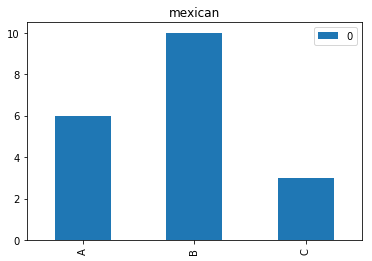

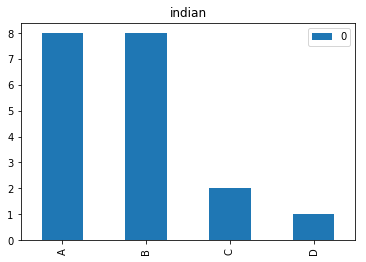

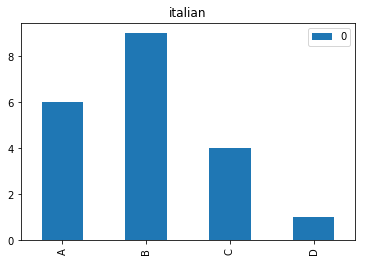

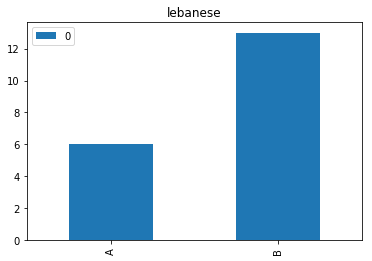

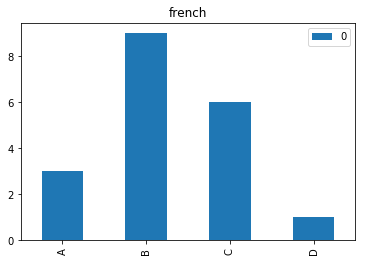

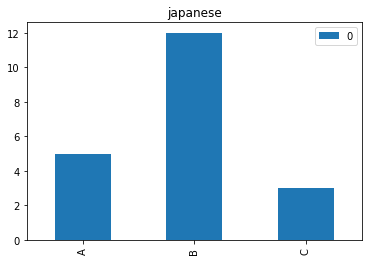

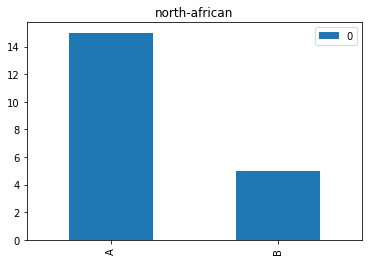

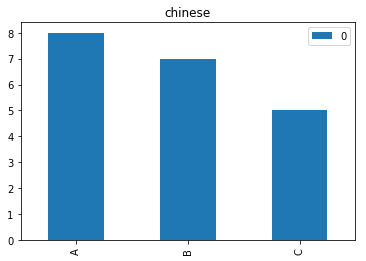

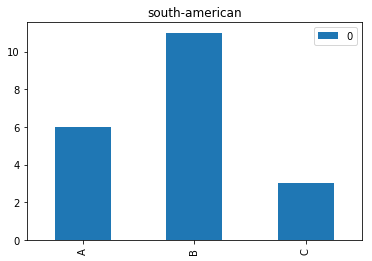

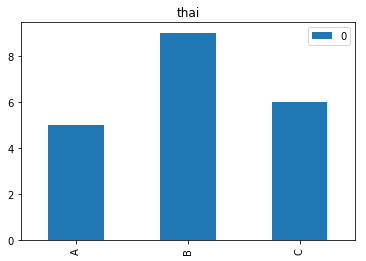

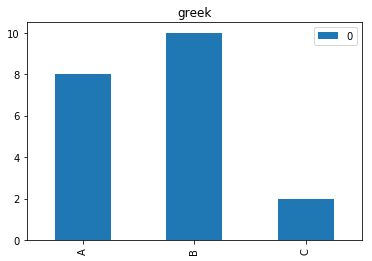

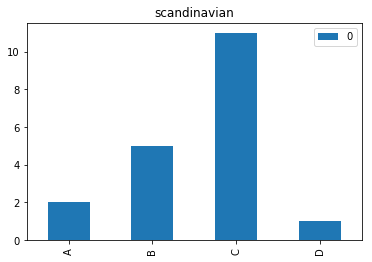

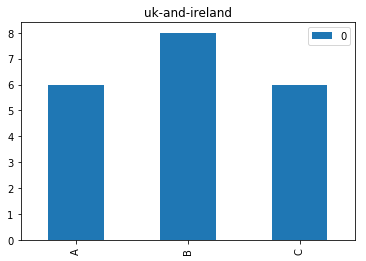

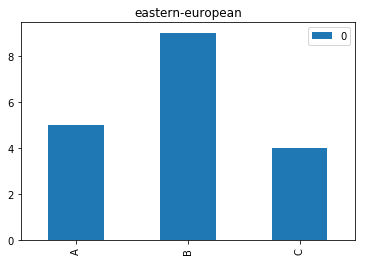

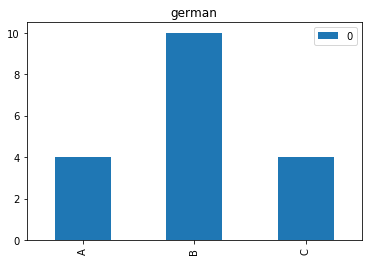

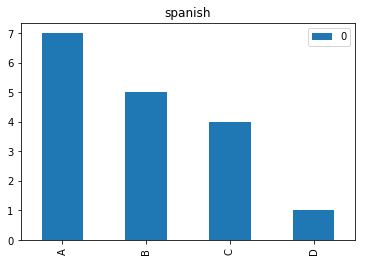

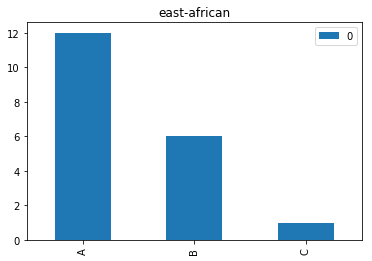

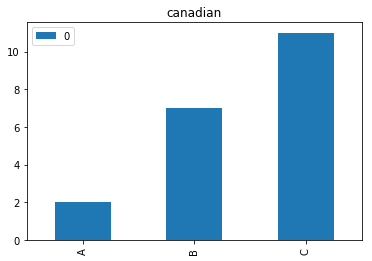

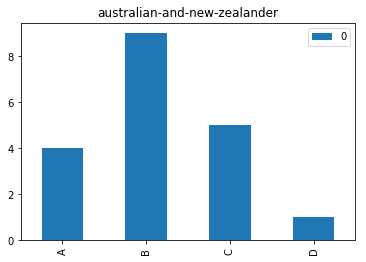

In [102]:
regions = Full['Region'].unique()
for region in regions:
    a=Full[Full['Region']==region].sort_values(by=['NutriScore'])['NutriLetter'].values
    letter_counts = Counter(a)
    df = pd.DataFrame.from_dict(letter_counts,orient = 'index')
    df.plot(kind='bar')
    plt.title(region)
    

In [103]:
Full.to_csv('data/fullWithNutri.csv')

## Tensorflow magic ##

In [ ]:
temp_path = 'tmp/'
ingDic = {}

for region in regions:
    jsonPath='data/'+region+'.json'
    with open(jsonPath, 'rb') as f:
        fullTheme=json.load(f)
    tmp = ''
    for recipe in fullTheme:
        #print(fullTheme[recipe])
        ingList=ingr2dic(fullTheme[recipe]['Ingredients'])
        for ing in ingList:
            tmp += ingList[ing]['name'].lstrip() + ', '
    ingDic[region] = tmp       

### See Google Colab notebook for code and results ###

The following figure is a similarity graph by running the parsed (without quantities) ingredient lists of all themes through the Google Universal Sentence Encoder and computing the correlation matrix.

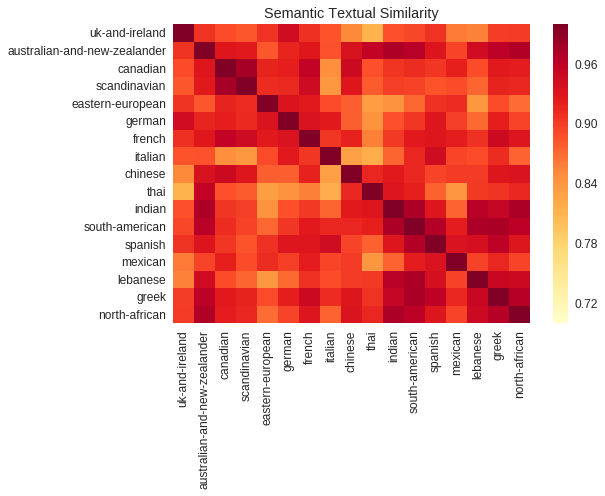

This is the graph formed with the highest connections.

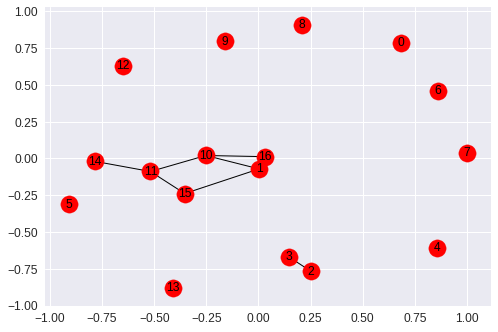

# Let's put some ML up in this bitch #

### Attempt at decision tree ###

In [117]:
from sklearn.preprocessing import StandardScaler

data = Full.drop(columns=['Popularity','Rating','Title','Reference','Vitamin A','NutriLetter'])
y= data.dropna()['Region']
X=StandardScaler().fit_transform(data.drop(columns=['Region']).dropna())

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


/home/manuel/anaconda3/envs/ada2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/manuel/anaconda3/envs/ada2/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


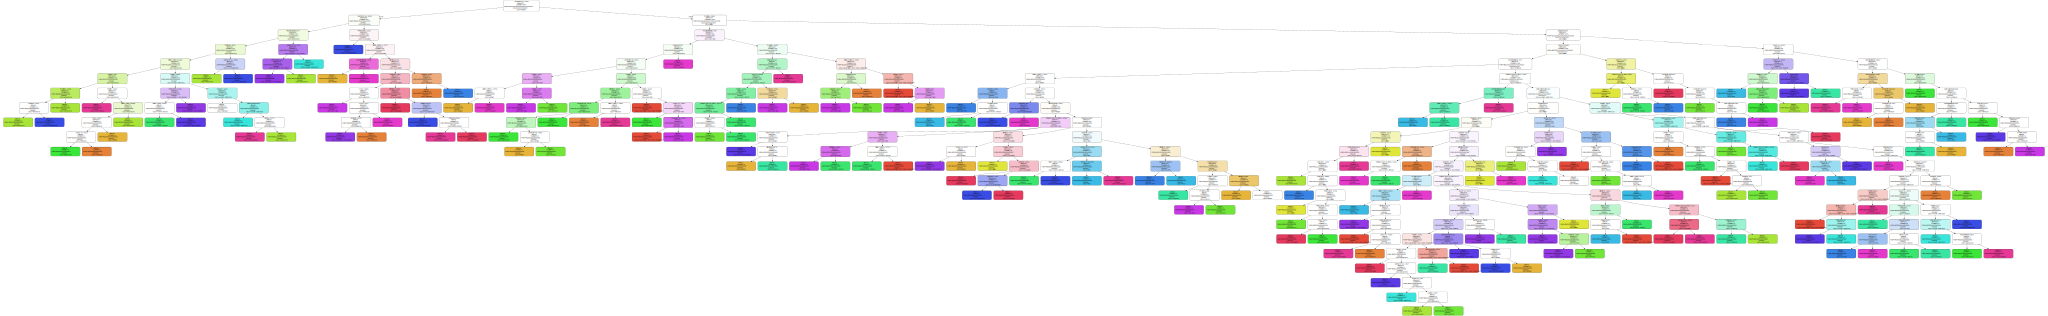

In [121]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

import graphviz 

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=data.drop(columns=['Region']).columns,  
                         class_names=regions,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Attempt at PCA ###

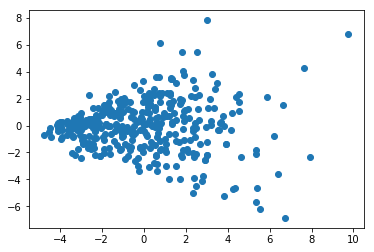

In [123]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

plt.scatter(principalDf['principal component 1'],principalDf['principal component 2'])


### Attempt at DBScan ###

Automatically created module for IPython interactive environment
Estimated number of clusters: 5
Estimated number of noise points: 195
Homogeneity: 0.048
Completeness: 0.137
V-measure: 0.071
Adjusted Rand Index: 0.003
Adjusted Mutual Information: 0.007
Silhouette Coefficient: -0.049


/home/manuel/anaconda3/envs/ada2/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


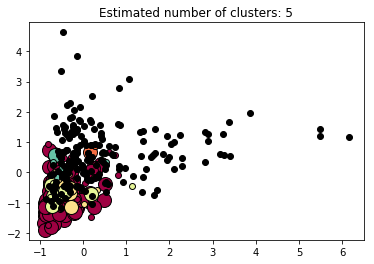

In [149]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# Compute DBSCAN
db = DBSCAN(eps=2, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

labels_true = y

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [150]:
Full.iloc[labels == 0]['NutriScore'].describe()

count    137.000000
mean       0.386861
std        3.032297
min       -8.000000
25%       -1.000000
50%        1.000000
75%        2.000000
max        9.000000
Name: NutriScore, dtype: float64

In [151]:
Full.iloc[labels == 1]

,Calcium,Calories,Cholesterol,Dietary Fiber,Folate,Iron,Magnesium,Niacin,Popularity,Potassium,...,Thiamin,Title,Total Carbohydrates,Total Fat,Vitamin A,Vitamin B6,Vitamin C,VeggieWeight,NutriScore,NutriLetter
Italian Spaghetti Sauce with Meatballs,140.0,349,77.0,4.5,46.0,6.0,59.0,9.0,4000.0,1023.0,...,0.0,Italian Spaghetti Sauce with Meatballs,23.7,21.2,825IU,1.0,33.0,363.0,-1,A
Mellas Family Lamb Stuffed Zucchini (Koosa),129.0,511,76.0,5.0,86.0,5.0,79.0,12.0,14.0,1185.0,...,0.0,Mellas Family Lamb Stuffed Zucchini (Koosa),44.8,26.6,762IU,1.0,49.0,326.0,-2,A
Spanakopita (Greek Spinach Pie),495.0,494,100.0,7.4,391.0,8.0,175.0,7.0,905.0,1304.0,...,0.0,Spanakopita (Greek Spinach Pie),31.5,34.7,12264IU,1.0,62.0,236.0,0,B
Diane's Colcannon,59.0,250,26.0,4.6,46.0,1.0,43.0,3.0,843.0,756.0,...,0.0,Diane's Colcannon,29.8,12.6,258IU,1.0,45.0,190.0,-1,A
The Best Steak Marinade,28.0,156,0.0,0.2,4.0,1.0,9.0,1.0,1000.0,188.0,...,0.0,The Best Steak Marinade,7.8,13.5,14IU,0.0,3.0,1.0,3,C
